## 8.1 序列模型

#### 8.1.1.1 自回归模型

输入数据的数量会醉着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理，
- 第一种策略。我们只需要满足某个长度为$\tau$的时间跨度，即使用观察序列$x_{t-1}, x_{t-2}, ..., x_{T-\tau}$.这样使我们能够训练一个深度网络，这种模型被称为**自回归模型**(autoregressive models)
- 第二种策略，是保留一些对过去观测的总结$h_t$，并同时更新预测$\hat{x}$和总结$h_t$.由于$h_t$从来没有被观测到，这种模型也被称为**隐变量自回归模型**(latent autoregressive models)

### 8.1.2 训练
使用正弦函数和一些可加性噪声来生成时间序列数据，时间步为1, 2, ..., 1000

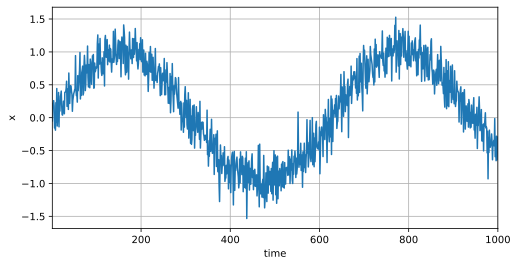

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(8, 4))

将数据映射为数据对$y_t=x_t$和$\mathbf{x_t}=[x_{t-\tau}, ..., x_{t-1}]$

In [9]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机

In [12]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss()

训练模型

In [24]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch{epoch+1}',
              f'loss:{d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch1 loss:0.070748
epoch2 loss:0.061549
epoch3 loss:0.057778
epoch4 loss:0.054979
epoch5 loss:0.054674


模型预测下一个时间步

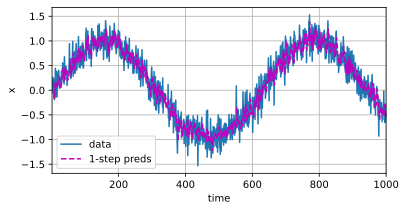

In [26]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)

进行多步预测

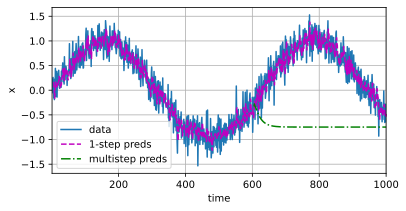

In [29]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？事实是由于错误的累积.       
基于$k=1, 4, 16, 64$，通过对整个序列预测的计算， 让我们更仔细地看一下$k$步预测的困难。

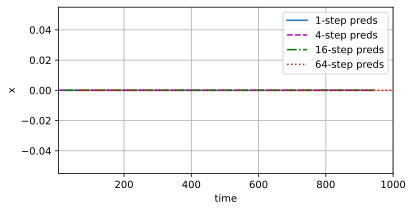

In [30]:
max_steps = 64
features = torch.zeros((T - tau - max_steps +1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T -tau - max_steps +1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))